<a href="https://colab.research.google.com/github/georgilos/Bert-for-text-classification/blob/main/SPAL%2BBert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Cloning the repository containing itinial training data, evaluation & unlabeled data

In [ ]:
!git clone https://github.com/georgilos/Bert-for-text-classification.git

Cloning into 'Bert-for-text-classification'...
remote: Enumerating objects: 201, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 201 (delta 32), reused 18 (delta 7), pack-reused 137 (from 1)
Receiving objects: 100% (201/201), 37.69 MiB | 17.01 MiB/s, done.
Resolving deltas: 100% (81/81), done.


### Changing to correct directory

In [ ]:
%cd Bert-for-text-classification/

/content/Bert-for-text-classification


### Checking that we are in the correct directory and the data directories are present

In [ ]:
%ls

Active+BERT.ipynb            diversity_sampling.py  pytorch_clusters.py  training_data/
active_learning_basics.py    evaluation_data/       README.md            uncertainty_sampling.py
active_learning.py           LICENSE                requirements.txt     unlabeled_data/
advanced_active_learning.py  models/                SPAL+Bert.ipynb      validation_data/


### Checking gpu is on

In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### Reading the .csv files


In [ ]:
import pandas as pd

# Load training data
train_hate = pd.read_csv('training_data/related.csv', header=None)
train_non_hate = pd.read_csv('training_data/not_related.csv', header=None)

# Load evaluation data
eval_hate = pd.read_csv('evaluation_data/related.csv', header=None)
eval_non_hate = pd.read_csv('evaluation_data/not_related.csv', header=None)

# Load unlabeled data
unlabeled_data = pd.read_csv('unlabeled_data/unlabeled_data.csv', header=None)

# Assign column names
columns = ['ID', 'TEXT', 'LABEL', 'UNKNOWN1', 'UNKNOWN2']
train_hate.columns = train_non_hate.columns = eval_hate.columns = eval_non_hate.columns = columns
unlabeled_data.columns = ['ID', 'TEXT']  # Unlabeled data doesn't have LABEL

# Keep only relevant columns
train_hate = train_hate[['ID', 'TEXT', 'LABEL']]
train_non_hate = train_non_hate[['ID', 'TEXT', 'LABEL']]
eval_hate = eval_hate[['ID', 'TEXT', 'LABEL']]
eval_non_hate = eval_non_hate[['ID', 'TEXT', 'LABEL']]
unlabeled_data = unlabeled_data[['ID', 'TEXT']]  # Unlabeled data has no labels

# Combine training and evaluation data
train_data = pd.concat([train_hate, train_non_hate], ignore_index=True)
eval_data = pd.concat([eval_hate, eval_non_hate], ignore_index=True)

# Inspect the datasets
print("Training Data:")
print(len(train_data))
print(train_data.head())
print("Evaluation Data:")
print(len(eval_data))
print(eval_data.head())
print("Unlabeled Data:")
print(len(unlabeled_data))
print(unlabeled_data.head())


Training Data:
95
         ID                                               TEXT  LABEL
0  10241698  employees are either pedophiles or trying to r...      1
1  10238878  how about this lets go to retard war lets see ...      1
2  10119028                     lol you sick whiny tds pussies      1
3  10536279  she is a dumbass a public embarrassment for he...      1
4  10236262  i wanted to reply lets goooooo brandon but i d...      1
Evaluation Data:
1198
       ID                                               TEXT  LABEL
0  585871  bitch i turn on the tv and is drunk af also ho...      1
1  215768  hicks and hillbillies are taking over the repu...      1
2  311431  the whole bunch is pure trash including the se...      1
3  452016  these gay drunk dudes on are very embarrassing...      1
4  109292  this dude is drunk af and crosseyed on in the ...      1
Unlabeled Data:
5001
         ID                                               TEXT
0  10000000  if youre going down might as well g

###Checking an instance of the training data contents (not necessary)



In [ ]:
print( train_data.iloc[9])

ID                                          10942227
TEXT     twitter is retarded and they aren't doctors
LABEL                                              1
Name: 9, dtype: object


### We combine train and evaluation set to extract more constraints **(not needed since the algorithm starts with no known constraints)**

In [ ]:
labeled_data = pd.concat([train_data, eval_data], ignore_index=True)
print("Labeled Data:")
print(len(labeled_data))
print(labeled_data.head())

Labeled Data:
1293
         ID                                               TEXT  LABEL
0  10241698  employees are either pedophiles or trying to r...      1
1  10238878  how about this lets go to retard war lets see ...      1
2  10119028                     lol you sick whiny tds pussies      1
3  10536279  she is a dumbass a public embarrassment for he...      1
4  10236262  i wanted to reply lets goooooo brandon but i d...      1


#### Finding Must - link pairs from the train_data (not needed)

In [ ]:
from itertools import combinations

def generate_must_link(data):
    same_class_pairs = []
    for label in data['LABEL'].unique():
        subset = data[data['LABEL'] == label]
        same_class_pairs.extend(list(combinations(subset.index, 2)))
    return same_class_pairs

must_link_pairs = generate_must_link(labeled_data)
print("First 5 Must-Link Pairs:", must_link_pairs[:5])  # Show first 5 pairs
print ("Totat Must-Link Pairs:", len(must_link_pairs))

First 5 Must-Link Pairs: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5)]
Totat Must-Link Pairs: 705369


#### Checking the contents of a must-link pair (not needed)

In [ ]:
# Access the contents of a random must-link pair
random_must_link_pair = must_link_pairs[4000] #select a pair
print("Random Must-Link Pair Indices:", random_must_link_pair)

# Access the corresponding data points
random_must_link_pair_data = labeled_data.iloc[list(random_must_link_pair)]
pd.set_option('display.max_colwidth', None)  # Show full text
print("\nData for the first Must-Link Pair:\n", random_must_link_pair_data)

Random Must-Link Pair Indices: (129, 192)

Data for the first Must-Link Pair:
          ID  \
129  316629   
192  396509   

                                                                                                                                                           TEXT  \
129  thats because youre an uncle tom what we would call a house nigga your wan na be white privilege is obviousyoure a joke to your uniform and your existance   
192                                                                                          go eat some fried chicken and watermellon you black nigger monkeys   

     LABEL  
129      1  
192      1  


#### Finding cannot-link pairs from the train_data (not needed)

In [ ]:
def generate_cannot_link(data):
    hate_indices = data[data['LABEL'] == 1].index
    non_hate_indices = data[data['LABEL'] == 0].index
    return [(i, j) for i in hate_indices for j in non_hate_indices]

cannot_link_pairs = generate_cannot_link(labeled_data)
print("First 5 Cannot-Link Pairs:", cannot_link_pairs[:5])  # Show first 5 pairs
print ("Total Cannot-Link Pairs:", len(cannot_link_pairs))

First 5 Cannot-Link Pairs: [(0, 10), (0, 11), (0, 12), (0, 13), (0, 14)]
Total Cannot-Link Pairs: 132496


#### Checking the contents of a cannot-link pair (not needed)

In [ ]:
# Access the contents of a random cannot-link pair
random_cannot_link_pair = cannot_link_pairs[14444]
print("First Cannot-Link Pair Indices:", random_cannot_link_pair)

# Access the corresponding data points
random_cannot_link_pair_data = labeled_data.iloc[list(random_cannot_link_pair)]
print("\nData for the first Cannot-Link Pair:\n", random_cannot_link_pair_data)

First Cannot-Link Pair Indices: (97, 360)

Data for the first Cannot-Link Pair:
          ID  \
97   311431   
360  785884   

                                                                                                                                                                                                                                                                                       TEXT  \
97                                                                                                                                                                   the whole bunch is pure trash including the self appointed spokeswoman for the gay bunch he will be the next one to go   
360  absolute nonsequitur there ' s a reason we have a standing military of professionals who join voluntarily and are highly trained when someone favors a policy that calls for its deployment to secure our interests to reply  why don ' t you go join  is irrelevant and manipulative   

     LABEL 

### Creating the first BERT embeddings of the training and unlabeled data (not necessary if downloaded from previous sessions)

In [ ]:
from transformers import BertTokenizer, BertModel
import torch


# Initialize tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def generate_embeddings(texts, tokenizer, model, batch_size=16, use_cls=True):

    embeddings = []
    for i in range(0, len(texts), batch_size):  # Create batches
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, padding=True, truncation=True, return_tensors="pt", max_length=128)
        with torch.no_grad():
            outputs = model(**inputs)
        if use_cls:
            # Extract [CLS] token embedding
            # `outputs.last_hidden_state` is a tensor of shape (batch_size, sequence_length, hidden_size)
            # We use the `[CLS]` token's embedding for each sentence (index 0 along sequence_length)
            batch_embeddings = outputs.last_hidden_state[:, 0, :]
        else:
            # Apply mean pooling
            batch_embeddings = outputs.last_hidden_state.mean(dim=1)
        embeddings.append(batch_embeddings)

    # Stack all embeddings into a single tensor
    return torch.cat(embeddings, dim=0)


# Generate embeddings for labeled data (train_data)
train_texts = train_data['TEXT'].tolist()
train_embeddings = generate_embeddings(train_texts, tokenizer, model, batch_size=16, use_cls=True)
print("Train Embeddings Shape:", train_embeddings.shape)

# Generate embeddings for labeled data (eval_data)
eval_texts = eval_data['TEXT'].tolist()
eval_embeddings = generate_embeddings(eval_texts, tokenizer, model, batch_size=16, use_cls=True)
print("Evaluation Embeddings Shape:", eval_embeddings.shape)

# Generate embeddings for unlabeled data
#unlabeled_texts = unlabeled_data['TEXT'].tolist()
#unlabeled_embeddings = generate_embeddings(unlabeled_texts, tokenizer, model, batch_size=16, use_cls=True)
#print("Unlabeled Embeddings Shape:", unlabeled_embeddings.shape)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Train Embeddings Shape: torch.Size([95, 768])
Evaluation Embeddings Shape: torch.Size([1198, 768])


### Saving  embeddings in the main directory

In [ ]:
# Save train embeddings
torch.save(train_embeddings, 'train_embeddings.pt')

# Save unlabeled embeddings
torch.save(eval_embeddings, 'eval_embeddings.pt')


### Download them to avoid recomputing them for future sessions

In [ ]:
from google.colab import files

files.download('/content/Bert-for-text-classification/eval_embeddings.pt')
files.download('/content/Bert-for-text-classification/train_embeddings.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Load embeddings (if downloaded from last session)

In [ ]:
import torch

# Paths to the saved .pt files
train_embeddings_path = 'train_embeddings.pt'
eval_embeddings_path = 'eval_embeddings.pt'

# Load the embeddings
train_embeddings = torch.load(train_embeddings_path)
eval_embeddings = torch.load(eval_embeddings_path)

print("Train Embeddings Shape:", train_embeddings.shape)
print("Evaluation Embeddings Shape:", eval_embeddings.shape)


Train Embeddings Shape: torch.Size([95, 768])
Evaluation Embeddings Shape: torch.Size([1198, 768])


<ipython-input-11-5de9ea76f849>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_embeddings = torch.load(train_embeddings_path)
<ipython-input-11-5de9ea76f849>:9: Futu

### Combine train and unlabeled embeddings into a single embedding

In [ ]:
# Combine labeled and unlabeled embeddings
all_embeddings = torch.cat((train_embeddings, eval_embeddings), dim=0)
print("Combined Embeddings Shape:", all_embeddings.shape)


Combined Embeddings Shape: torch.Size([1293, 768])


### Compute the pairwise distance matrix used for clustering (NumPy)

In [ ]:
from scipy.spatial.distance import cdist
import numpy as np

# Convert embeddings to NumPy array if necessary
embeddings = all_embeddings.numpy()  # Combined embeddings from labeled and unlabeled data

# Compute pairwise distance matrix
distance_matrix = cdist(embeddings, embeddings, metric='cosine')
print("Distance Matrix Shape:", distance_matrix.shape)
print("Distance Matrix:", distance_matrix)

Distance Matrix Shape: (1293, 1293)
Distance Matrix: [[0.         0.24914965 0.20283401 ... 0.20597387 0.23425812 0.18842239]
 [0.24914965 0.         0.16507129 ... 0.25066164 0.23092601 0.17286396]
 [0.20283401 0.16507129 0.         ... 0.13724159 0.21243032 0.15075666]
 ...
 [0.20597387 0.25066164 0.13724159 ... 0.         0.21514214 0.16695153]
 [0.23425812 0.23092601 0.21243032 ... 0.21514214 0.         0.16691482]
 [0.18842239 0.17286396 0.15075666 ... 0.16695153 0.16691482 0.        ]]


### Plotting the values of distance matrix to select a suitable eps value

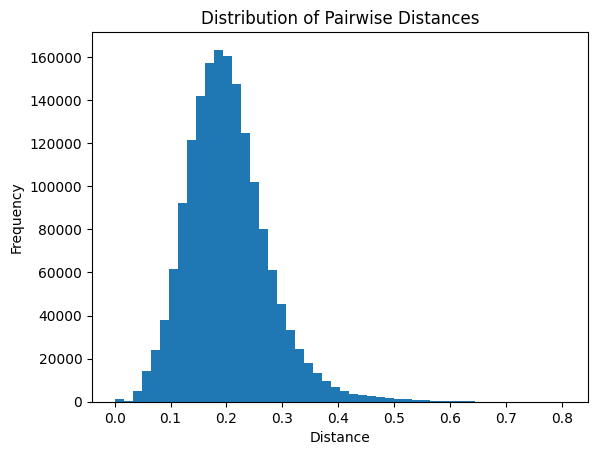

In [ ]:
import matplotlib.pyplot as plt
plt.hist(distance_matrix.flatten(), bins=50)
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.title("Distribution of Pairwise Distances")
plt.show()

#### We can see that the most common distance is 0.17

### Constrained DBSCAN clustering function (with NumPy)


In [ ]:
import numpy as np
from collections import deque

def constrained_dbscan_with_constraints(distance_matrix, eps, min_samples, must_link, cannot_link):
    """
    Constrained DBSCAN implementation where constraints are applied during clustering.

    Parameters:
    - distance_matrix (ndarray): Pairwise distance matrix.
    - eps (float): Maximum distance to consider two points as neighbors.
    - min_samples (int): Minimum number of neighbors for a point to be a core point.
    - must_link (list of tuples): List of must-link pairs (index1, index2).
    - cannot_link (list of tuples): List of cannot-link pairs (index1, index2).

    Returns:
    - labels (ndarray): Cluster labels for each point. Noise is labeled as -1.
    """
    n = distance_matrix.shape[0]  # Get the total number of data points (number of rows(or columns) in the distance matrix).
    labels = np.full(n, -1)  # Initialize all points as noise (-1)
    cluster_id = 0  # Start with cluster ID 0

    # Convert must-link and cannot-link constraints into dictionaries for quick lookup
    must_link_dict = {i: set() for i in range(n)}
    for i, j in must_link:
        must_link_dict[i].add(j)
        must_link_dict[j].add(i)

    cannot_link_dict = {i: set() for i in range(n)}
    for i, j in cannot_link:
        cannot_link_dict[i].add(j)
        cannot_link_dict[j].add(i)

    # Visit each point
    visited = np.full(n, False)  # Checks if a point is unvisited and not yet part of a cluster

    def expand_cluster(point_idx):
        # Initialising a double-ended queue to store points for Breadth-First Search
        queue = deque([point_idx])  # Add the index of the initial point to it
        cluster_points = []  # Points that will be part of this cluster
        #(BFS as long as there are points in the deque to be explored)
        while queue:
            current_point = queue.popleft()  # Retrieve and remove the leftmost element from the queue
            if visited[current_point]:  # If a point is visited
                continue  # Skip this point
            is_valid = True
            for other_point in cluster_points:
                if current_point in cannot_link_dict[other_point]:
                    is_valid = False
                    break  # Stop checking if violation is found

            if not is_valid:
                # Handle cannot-link violation:
                # labels[current_point] = -1  # Option 1: Assign to noise
                continue  # Option 2: Skip this point and prevent further expansion
            visited[current_point] = True  # When a point passes the constraint check, mark it as
            cluster_points.append(current_point)  # Add point to the cluster_points list

            # Get neighbors of the current point based on pre-calculated distances in distance_matrix.
            # Points within a distance of 'eps' are considered neighbors.
            # np.where(...) returns indices of neighbors (using [0]).
            neighbors = np.where(distance_matrix[current_point] <= eps)[0]

            # Ensure cannot-link constraints are not violated
            valid_neighbors = []
            for neighbor in neighbors:
                # Check for direct cannot-link violations with all points in the cluster
                if any(neighbor in cannot_link_dict[other_point] for other_point in cluster_points):
                    continue  # Skip this neighbor, as it creates a cannot-link violation
                valid_neighbors.append(neighbor)

            # Add must-link neighbors to the cluster and queue
            for p in must_link_dict[current_point]:
                if p not in cluster_points:
                    queue.append(p)

            # If the current point has enough neighbors, include them in the cluster
            if len(valid_neighbors) >= min_samples:
                for neighbor in valid_neighbors:
                    if neighbor not in cluster_points:
                        queue.append(neighbor)

        # Assign the cluster ID to all points in the cluster
        for p in cluster_points:
            labels[p] = cluster_id

    for i in range(n):
        if visited[i] or labels[i] != -1:  # Skip visited or already clustered points
            continue

        # Check if the point is a core point
        neighbors = np.where(distance_matrix[i] <= eps)[0]
        if len(neighbors) < min_samples:
            continue  # Not a core point, remains noise

        # Expand the cluster
        expand_cluster(i)
        cluster_id += 1

    return labels


### Since it is the first time we implement the clustering algorithm, the constraints lists should be empty

In [ ]:
must_link_pairs = []
cannot_link_pairs = []

### Executing constrained DBSCAN (with NumPy) ()

In [ ]:
# Apply constrained DBSCAN
eps = 0.13  # Adjust based on distance matrix
min_samples = 2  # Minimum neighbors to form a cluster

adjusted_labels = constrained_dbscan_with_constraints(distance_matrix, eps, min_samples, must_link_pairs, cannot_link_pairs)
print("Adjusted Cluster Labels:", np.unique(adjusted_labels))

Adjusted Cluster Labels: [-1  0  1  2]


### Visualisation of clustering (not necessary)

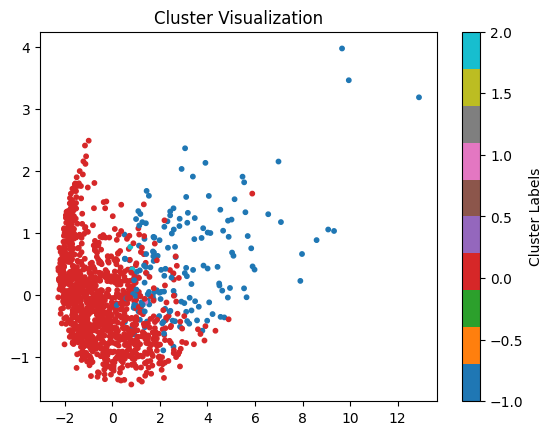

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce to 2D for visualization
reduced_embeddings = PCA(n_components=2).fit_transform(distance_matrix)

# Plot clusters
plt.scatter(
    reduced_embeddings[:, 0], reduced_embeddings[:, 1],
    c=adjusted_labels, cmap='tab10', s=10
)
plt.colorbar(label="Cluster Labels")
plt.title("Cluster Visualization")
plt.show()



### Number of noise points (not necessary)

In [ ]:
noise_points = [i for i, label in enumerate(adjusted_labels) if label == -1]
print(f"Number of Noise Points: {len(noise_points)}")


Number of Noise Points: 171


### Find the text of the first 15 instances of each cluster (not necessary)

In [ ]:
import pandas as pd

all_texts = train_data['TEXT'].tolist() + eval_data['TEXT'].tolist() #+ unlabeled_data['TEXT'].tolist()

# Combine embeddings, labels, and texts into a DataFrame
clustered_data = pd.DataFrame({
    'TEXT': all_texts,
    'CLUSTER': adjusted_labels  # From clustering
})

# Group by clusters and inspect
for cluster_id in np.unique(adjusted_labels):
    pd.set_option('display.max_colwidth', None)  # Set to None for unlimited width
    print(f"\nCluster {cluster_id}:")
    print(clustered_data[clustered_data['CLUSTER'] == cluster_id].head(15))  # Inspect first 15 texts



Cluster -1:
                                                                                                                                                                                                                                            TEXT  \
8                                                                                                            finally that hoe is batshit crazy face with tears of joyclapping hands: medium-light skin toneraising hands: medium-light skin tone   
13                                                                                                                                                                                         people who live in seattle and portland and baltimore   
23                                                                                                                                                  college freshman torches and at disinformation conference calls out medias lies and coverups   
24         

### Number of instances in each cluster

In [ ]:
from collections import Counter

# Count the instances in each cluster
cluster_counts = Counter(adjusted_labels)

# Print the cluster counts
for cluster_id, count in cluster_counts.items():
    print(f"Cluster {cluster_id}: {count} instances")

Cluster 0: 1118 instances
Cluster -1: 171 instances
Cluster 1: 2 instances
Cluster 2: 2 instances


### If it is not the first time performing clustering, we must now update the memory. Otherwise skip this step and proceed with memory initialation

In [ ]:
# def update_memory_bank(memory_bank, embeddings, cluster_labels):

### Function for memory bank initialization to store centroids used for Lc loss

In [ ]:
import torch
import torch.nn.functional as F

def initialize_memory_bank(embeddings, cluster_labels):
    """
    Initialize the memory bank with cluster centroids (PyTorch version).

    Parameters:
    - embeddings (torch.Tensor): Embeddings of all data points (n x d).
    - cluster_labels (torch.Tensor): Cluster labels for each data point.

    Returns:
    - memory_bank (dict): A dictionary where keys are cluster IDs and values are centroids.
    """
    memory_bank = {}  # Initialize memory_bank as a dictionary
    # Ensure cluster_labels are on the same device as embeddings:
    cluster_labels = cluster_labels.to(embeddings.device)
    unique_clusters = torch.unique(cluster_labels[cluster_labels != -1])  # Exclude noise (-1)
    for cluster in unique_clusters:
        cluster_indices = torch.where(cluster_labels == cluster)[0]  # Find points in the cluster
        cluster_embeddings = embeddings[cluster_indices]  # Get embeddings for the cluster
        centroid = cluster_embeddings.mean(dim=0)  # Compute centroid
        centroid = F.normalize(cluster_embeddings.mean(dim=0), p=2, dim=0)
        memory_bank[int(cluster.item())] = centroid  # Store as tensor in memory bank
    return memory_bank

# Resetting memory_bank
memory_bank = {}

# Making sure that adjusted_labels are PyToch tensors
adjusted_labels= torch.tensor(adjusted_labels, dtype=torch.int64)

# Move all_embeddings to the desired device (e.g., CPU):
device = 'cuda' if torch.cuda.is_available() else 'cpu'
all_embeddings = all_embeddings.to(device)

#Creating memory bank
memory_bank = initialize_memory_bank(all_embeddings, adjusted_labels)
print(f"Memory Bank Initialized: {memory_bank}")

Memory Bank Initialized: {0: tensor([-6.6903e-04,  9.5836e-03,  1.3200e-03, -2.4435e-03, -1.9431e-02,
        -2.4383e-02,  2.3319e-02,  3.8326e-02, -2.2643e-03, -1.6380e-02,
         1.2477e-02, -4.4630e-03, -2.9178e-03,  2.6695e-02,  5.9723e-03,
         8.9374e-04, -1.7837e-02,  2.6399e-02,  1.9204e-02, -1.1763e-03,
        -8.4938e-04, -2.5551e-02,  8.0078e-03, -7.1083e-03,  2.9514e-03,
        -8.0462e-03,  8.7763e-04, -1.1393e-02,  1.7223e-04,  7.3578e-03,
         1.0184e-03,  1.6782e-02, -1.7778e-02, -6.2511e-03,  1.2695e-02,
        -5.0675e-03,  1.2502e-02,  1.5149e-03,  6.9315e-03,  6.1314e-03,
        -1.2763e-02,  3.5631e-03,  5.7884e-03, -1.3363e-04, -2.2041e-03,
        -2.0654e-02, -2.0826e-01, -7.6574e-03, -1.1451e-02, -1.9349e-02,
         1.4993e-02, -1.4108e-02,  6.6851e-03,  1.8552e-02,  7.3995e-03,
         2.2101e-02, -2.6595e-02,  2.5200e-02, -3.9087e-03,  1.0563e-02,
         1.5195e-02,  1.5470e-03, -1.1200e-02,  3.8628e-04, -1.9491e-03,
         1.0057e-02, -

### Lc loss calculation function (will be used in the training loop)

In [ ]:
import torch

def calculate_contrastive_loss(memory_bank, embeddings, cluster_labels, temperature=0.5):
    """
    Calculate the contrastive loss (L_c) based on instance-to-centroid contrastive loss.

    Parameters:
    - memory_bank (dict): Dictionary containing cluster centroids (keys: cluster labels, values: centroids).
    - embeddings (torch.Tensor): Current embeddings of the instances (shape: [n_instances, embedding_dim]).
    - cluster_labels (ndarray): Cluster labels for each instance (shape: [n_instances]).
    - temperature (float): Temperature factor (tau) for scaling the logits.

    Returns:
    - loss (torch.Tensor): Calculated contrastive loss.
    """
    # Filter out noise points (cluster label == -1)
    valid_indices = cluster_labels != -1
    valid_embeddings = embeddings[valid_indices]
    valid_embeddings = F.normalize(valid_embeddings, p=2, dim=1)
    valid_labels = cluster_labels[valid_indices]

    # Prepare the centroids for all valid points
    # Change: Convert valid_labels elements to Python integers before using them as keys
    centroids = torch.stack([memory_bank[int(label.item())] for label in valid_labels])
    centroids = F.normalize(centroids, p=2, dim=1)

    # Calculate logits: instance-to-centroid similarity
    batch_size = 8  # Adjust based on available memory
    logits = []
    for i in range(0, len(valid_embeddings), batch_size):
        batch_embeddings = valid_embeddings[i:i + batch_size]
        batch_logits = torch.mm(batch_embeddings, centroids.T) / temperature
        logits.append(batch_logits)
    logits = torch.cat(logits, dim=0)  # Concatenate all batches

    # Create the labels for the contrastive loss
    # Each instance is only "positive" with its own cluster centroid
    labels = torch.arange(len(valid_embeddings)).to(logits.device)

    # Calculate contrastive loss using CrossEntropyLoss
    criterion = torch.nn.CrossEntropyLoss()
    loss = criterion(logits, labels)

    return loss

### Uncertain negative & uncertain positive pairs extraction function

In [ ]:
import numpy as np

def select_uncertain_pairs(distance_matrix, cluster_labels):
    """
    Select uncertain positive and negative pairs based on the clustering results and distance matrix.

    Parameters:
    - distance_matrix (ndarray): Pairwise distance matrix (n x n).
    - cluster_labels (ndarray): Cluster labels for each point.

    Returns:
    - uncertain_positive_pairs (list): List of (index1, index2, distance) for uncertain positive pairs.
    - uncertain_negative_pairs (list): List of (index1, index2, distance) for uncertain negative pairs.
    """
    uncertain_positive_pairs = []  # For storing uncertain positive pairs
    uncertain_negative_pairs = []  # For storing uncertain negative pairs

    unique_clusters = np.unique(cluster_labels[cluster_labels != -1])  # Ignore noise (-1)

    # Uncertain Positive Pairs
    for cluster in unique_clusters:
        cluster_indices = np.where(cluster_labels == cluster)[0]
        if len(cluster_indices) > 1:
            # Find the pair with the maximum distance within the cluster
            max_dist = -np.inf
            best_pair = None
            for i in cluster_indices:
                for j in cluster_indices:
                    if i < j:  # Avoid duplicate comparisons
                        dist = distance_matrix[i, j]
                        if dist > max_dist:
                            max_dist = dist
                            best_pair = (i, j, dist)
            if best_pair:
                uncertain_positive_pairs.append(best_pair)

    # Uncertain Negative Pairs
    for cluster1 in unique_clusters:
        for cluster2 in unique_clusters:
            if cluster1 < cluster2:  # Avoid duplicate comparisons
                cluster1_indices = np.where(cluster_labels == cluster1)[0]
                cluster2_indices = np.where(cluster_labels == cluster2)[0]
                # Find the pair with the minimum distance between the two clusters
                min_dist = np.inf
                best_pair = None
                for i in cluster1_indices:
                    for j in cluster2_indices:
                        dist = distance_matrix[i, j]
                        if dist < min_dist:
                            min_dist = dist
                            best_pair = (i, j, dist)
                if best_pair:
                    uncertain_negative_pairs.append(best_pair)

    return uncertain_positive_pairs, uncertain_negative_pairs


### Finding the uncertain pairs

In [ ]:
# Select uncertain pairs
uncertain_positive_pairs, uncertain_negative_pairs = select_uncertain_pairs(distance_matrix, adjusted_labels)

# Display results
print("Uncertain Positive Pairs (within clusters):")
for pair in uncertain_positive_pairs[:10]:
    print(f"Pair: {pair[0]} and {pair[1]}, Distance: {pair[2]:.4f}")

print("\nUncertain Negative Pairs (across clusters):")
for pair in uncertain_negative_pairs[:10]:
    print(f"Pair: {pair[0]} and {pair[1]}, Distance: {pair[2]:.4f}")


Uncertain Positive Pairs (within clusters):
Pair: 172 and 1239, Distance: 0.5131
Pair: 722 and 723, Distance: 0.0624
Pair: 750 and 1130, Distance: 0.1180

Uncertain Negative Pairs (across clusters):
Pair: 459 and 723, Distance: 0.1318
Pair: 279 and 1130, Distance: 0.1302
Pair: 723 and 750, Distance: 0.2539


### Finding the text and cluster for specific instances isntances (not necessary)

In [ ]:
# Insances 3151 and 4820 where parts on an uncertain positive pair
# Insances 703 and 46 where parts on an uncertain negative pair
all_texts = train_data['TEXT'].tolist() + eval_data['TEXT'].tolist() #+ unlabeled_data['TEXT'].tolist()

# Cluster label 3151 and 4820
print(f"Cluster Label: {adjusted_labels[723]}")

# Text
print(f"Text: {all_texts[723]}")


Cluster Label: 1
Text: what ' s your favorite drinking toast meet stanley tucci ' s new friend giorgionni and hear his wisdom on friendship wine and umbrian pork searchingforitaly tonight at p etpt on


###  Uncertain pairs annotation and updating constraints function

In [ ]:
def annotate_and_update_constraints(
    uncertain_positive_pairs, uncertain_negative_pairs,
    all_texts, must_link_pairs, cannot_link_pairs
):
    """
    Annotates uncertain pairs and updates must-link and cannot-link constraints.

    Parameters:
    - uncertain_positive_pairs (list): List of uncertain positive pairs (index1, index2, distance).
    - uncertain_negative_pairs (list): List of uncertain negative pairs (index1, index2, distance).
    - all_texts (list): List of texts corresponding to embeddings.
    - must_link_pairs (list): Existing list of must-link pairs (to be updated).
    - cannot_link_pairs (list): Existing list of cannot-link pairs (to be updated).

    Returns:
    - must_link_pairs: Updated must-link pairs.
    - cannot_link_pairs: Updated cannot-link pairs.
    """
    print("Annotating Uncertain Positive Pairs (Within Clusters):")
    for i, j, dist in uncertain_positive_pairs:
        print(f"\nPair: ({i}, {j}), Distance: {dist:.4f}")
        print(f"Text 1: {all_texts[i]}")
        print(f"Text 2: {all_texts[j]}")
        decision = input("Should these belong in the same cluster? (y/n): ").strip().lower()
        if decision == "y":
            must_link_pairs.append((i, j))
        elif decision == "n":
            cannot_link_pairs.append((i, j))

    print("\nAnnotating Uncertain Negative Pairs (Across Clusters):")
    for i, j, dist in uncertain_negative_pairs:
        print(f"\nPair: ({i}, {j}), Distance: {dist:.4f}")
        print(f"Text 1: {all_texts[i]}")
        print(f"Text 2: {all_texts[j]}")
        decision = input("Should these belong in different clusters? (y/n): ").strip().lower()
        if decision == "y":
            cannot_link_pairs.append((i, j))
        elif decision == "n":
            must_link_pairs.append((i, j))

    return must_link_pairs, cannot_link_pairs


### Let's annotate the pairs

In [ ]:
all_texts = train_data['TEXT'].tolist() + eval_data['TEXT'].tolist()

# Annotate the selected pairs
must_link_pairs, cannot_link_pairs = annotate_and_update_constraints(
    uncertain_positive_pairs, uncertain_negative_pairs,
    all_texts, must_link_pairs, cannot_link_pairs
)

# Confirm updates
print(f"Updated Must-Link Pairs: {len(must_link_pairs)}")
print(f"Updated Cannot-Link Pairs: {len(cannot_link_pairs)}")


Annotating Uncertain Positive Pairs (Within Clusters):

Pair: (172, 1239), Distance: 0.5131
Text 1: i ’ d rather cut my dick off than watch this trash
Text 2: id like to know mr musk who encouraged you to go to mars and what individual said that you were capable of doing this and what scientific proof did they give you that you could actually do what youre wanting to do
Should these belong in the same cluster? (y/n): n

Pair: (722, 723), Distance: 0.0624
Text 1: salumi prosciutto what else makes up the perfect charcuterie plate join stanley tucci for a tasting of umbria ' s truly unique pork products in searchingforitaly tonight at p etpt on
Text 2: what ' s your favorite drinking toast meet stanley tucci ' s new friend giorgionni and hear his wisdom on friendship wine and umbrian pork searchingforitaly tonight at p etpt on
Should these belong in the same cluster? (y/n): y

Pair: (750, 1130), Distance: 0.1180
Text 1: texas residents can now sue facebook twitter and youtube for allegedl

### Ensure that the new pairs have been added to the constraints lists (not necessary)

In [ ]:
# Access the last 5 instances added to must_link_pairs and cannot_link_pairs
print("\nMust-Link Pairs added:")
for pair in must_link_pairs: #[-5:]
    print(pair)

print("\nCannot-Link Pairs added:")
for pair in cannot_link_pairs :#[-5:]
    print(pair) #


Must-Link Pairs added:
(722, 723)
(750, 1130)
(459, 723)
(279, 1130)
(723, 750)

Cannot-Link Pairs added:
(172, 1239)


### Version 2 of Lt (correct one)

In [ ]:
import torch
import torch.nn.functional as F

def calculate_support_pair_loss(embeddings, must_link_pairs, cannot_link_pairs, margin=1.0):
    """
    Calculate the Support Pair Constraints Loss (L_t) based on must-link and cannot-link constraints.

    Parameters:
    - embeddings (torch.Tensor): Embedding matrix of shape (n_samples, embedding_dim).
    - must_link_pairs (list of tuples): List of (index1, index2) for must-link pairs.
    - cannot_link_pairs (list of tuples): List of (index1, index2) for cannot-link pairs.
    - margin (float): Margin for the triplet loss.

    Returns:
    - support_pair_loss (torch.Tensor): Calculated support pair loss (L_t).
    """
    # Normalize embeddings
    embeddings = F.normalize(embeddings, p=2, dim=1)

    # Precompute pairwise distances
    pairwise_distances = torch.cdist(embeddings, embeddings, p=2)

    triplet_losses = []

    for anchor_idx in range(embeddings.size(0)):
        positives = [j for (a, j) in must_link_pairs if a == anchor_idx] + \
                    [a for (a, j) in must_link_pairs if j == anchor_idx]
        negatives = [j for (a, j) in cannot_link_pairs if a == anchor_idx] + \
                    [a for (a, j) in cannot_link_pairs if j == anchor_idx]
        """
        if not positives or not negatives:
            # Constraint relaxation: If no positives or negatives, use all points as candidates
            if not positives:
                positives = [idx for idx in range(embeddings.size(0)) if idx != anchor_idx]
            if not negatives:
                negatives = [idx for idx in range(embeddings.size(0)) if idx != anchor_idx]
        """
        if positives:
            print(f"Anchor {anchor_idx} has {len(positives)} positives.")
        if negatives:
            print(f"Anchor {anchor_idx} has {len(negatives)} negatives.")

        if not positives or not negatives:
            continue



        # Find hardest positive and hardest negative
        hardest_positive_idx = torch.argmax(torch.tensor([pairwise_distances[anchor_idx, p] for p in positives]))
        hardest_positive = positives[hardest_positive_idx]

        hardest_negative_idx = torch.argmin(torch.tensor([pairwise_distances[anchor_idx, n] for n in negatives]))
        hardest_negative = negatives[hardest_negative_idx]

        # Compute triplet loss
        positive_distance = pairwise_distances[anchor_idx, hardest_positive]
        negative_distance = pairwise_distances[anchor_idx, hardest_negative]
        triplet_loss = F.relu(positive_distance - negative_distance + margin)
        triplet_losses.append(triplet_loss)

    # Average triplet losses
    if triplet_losses:
        support_pair_loss = torch.stack(triplet_losses).mean()
    else:
        support_pair_loss = torch.tensor(0.0, requires_grad=True)

    return support_pair_loss


### Lets train the bert-base-uncased model using the modular functions for clearer code:

In [ ]:
import os
import torch
from transformers import BertTokenizer, BertModel
import torch.nn.functional as F

# Initialize tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
model.train()  # Set model to training mode

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

# Hyperparameters
batch_size = 32
lambda_t = 1.0  # Weight for L_t
margin = 0.1  # Margin for triplet loss
temperature = 0.5  # Temperature for contrastive loss
num_epochs = 3
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model.to(device)

# Training loop
for epoch in range(num_epochs):
    for i in range(0, len(all_texts), batch_size):
        # Prepare batch data
        batch_texts = all_texts[i:i + batch_size]
        batch_indices = list(range(i, min(i + batch_size, len(all_texts))))
        batch_index_set = set(batch_indices)

        # Tokenize and generate embeddings
        inputs = tokenizer(batch_texts, padding=True, truncation=True, return_tensors="pt", max_length=128)
        inputs = {key: val.to(device) for key, val in inputs.items()}
        outputs = model(**inputs)
        embeddings = outputs.last_hidden_state[:, 0, :]  # [CLS] token embeddings

        # Filter must-link and cannot-link pairs for the current batch
        batch_must_link_pairs = [
            (a, b) for (a, b) in must_link_pairs if a in batch_index_set and b in batch_index_set
        ]
        batch_cannot_link_pairs = [
            (a, b) for (a, b) in cannot_link_pairs if a in batch_index_set and b in batch_index_set
        ]

        # Debugging: Number of pairs in batch
        print(f"Batch {i // batch_size + 1}: Must-Link Pairs in Batch: {len(batch_must_link_pairs)}, "
              f"Cannot-Link Pairs in Batch: {len(batch_cannot_link_pairs)}")

        # Create a mapping from global to batch-local indices
        index_map = {global_idx: local_idx for local_idx, global_idx in enumerate(batch_indices)}

        # Convert global indices in pairs to batch-local indices
        batch_must_link_pairs = [
            (index_map[a], index_map[b]) for (a, b) in batch_must_link_pairs
        ]
        batch_cannot_link_pairs = [
            (index_map[a], index_map[b]) for (a, b) in batch_cannot_link_pairs
        ]

        # Compute losses
        contrastive_loss = calculate_contrastive_loss(memory_bank, embeddings, adjusted_labels[batch_indices], temperature=temperature)
        support_pair_loss = calculate_support_pair_loss(embeddings, batch_must_link_pairs, batch_cannot_link_pairs, margin=margin)

        # Combine losses
        combined_loss = contrastive_loss + lambda_t * support_pair_loss

        # Backpropagation
        optimizer.zero_grad()
        combined_loss.backward()
        optimizer.step()

        # Debugging: Monitor losses
        print(f"Epoch {epoch + 1}, Batch {i // batch_size + 1}: Contrastive Loss = {contrastive_loss.item():.4f}, "
              f"Triplet Loss = {support_pair_loss.item():.4f}, Combined Loss = {combined_loss.item():.4f}")

# Save the fine-tuned model
save_path = "/content/Bert-for-text-classification/models/fine_tuned_bert.pth"
os.makedirs(os.path.dirname(save_path), exist_ok=True)
torch.save(model.state_dict(), save_path)
print(f"Fine-tuned BERT model saved to {save_path}")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Batch 1: Must-Link Pairs in Batch: 0, Cannot-Link Pairs in Batch: 0
Epoch 1, Batch 1: Contrastive Loss = 3.3322, Triplet Loss = 0.0000, Combined Loss = 3.3322
Batch 2: Must-Link Pairs in Batch: 0, Cannot-Link Pairs in Batch: 0
Epoch 1, Batch 2: Contrastive Loss = 3.2581, Triplet Loss = 0.0000, Combined Loss = 3.2581
Batch 3: Must-Link Pairs in Batch: 0, Cannot-Link Pairs in Batch: 0
Epoch 1, Batch 3: Contrastive Loss = 3.1355, Triplet Loss = 0.0000, Combined Loss = 3.1355
Batch 4: Must-Link Pairs in Batch: 0, Cannot-Link Pairs in Batch: 0
Epoch 1, Batch 4: Contrastive Loss = 3.3322, Triplet Loss = 0.0000, Combined Loss = 3.3322
Batch 5: Must-Link Pairs in Batch: 0, Cannot-Link Pairs in Batch: 0
Epoch 1, Batch 5: Contrastive Loss = 3.4012, Triplet Loss = 0.0000, Combined Loss = 3.4012
Batch 6: Must-Link Pairs in Batch: 0, Cannot-Link Pairs in Batch: 0
Epoch 1, Batch 6: Contrastive Loss = 3.4340, Triplet Loss = 0.0000, Combined Loss = 3.4340
Batch 7: Must-Link Pairs in Batch: 0, Cannot-L

### Saving the model in drive (not needed)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#Save the .params file from colab to gdrive
!cp /content/Bert-for-text-classification/models/fine_tuned_bert.pth /content/gdrive/MyDrive/Saved_models

### Loading from drive (not needed)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#Save the .params file from google drive to the /models directory
!cp /content/gdrive/MyDrive/Saved_models/20241105_204118_0.642_0.897_506.params /content/Bert-for-text-classification/models/

### Generating the new embeddings based on the updated Bert's weights

In [ ]:
from transformers import BertTokenizer, BertModel
import torch

# Define paths
fine_tuned_model_path = "/content/Bert-for-text-classification/models/fine_tuned_bert.pth"

# Step 1: Load the BERT Model Architecture
print("Loading the fine-tuned BERT model...")
model = BertModel.from_pretrained('bert-base-uncased')  # Reinitialize the architecture
model.load_state_dict(torch.load(fine_tuned_model_path))  # Load saved weights
model.eval()  # Set the model to evaluation mode to avoid updating weights during inference

# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Step 2: Function to Generate Embeddings
def generate_embeddings(texts, tokenizer, model, batch_size=16, use_cls=True):
    embeddings = []
    for i in range(0, len(texts), batch_size):  # Create batches
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, padding=True, truncation=True, return_tensors="pt", max_length=128)
        with torch.no_grad():  # Disable gradient tracking for inference
            outputs = model(**inputs)
        if use_cls:
            # Extract [CLS] token embedding
            batch_embeddings = outputs.last_hidden_state[:, 0, :]
        else:
            # Apply mean pooling
            batch_embeddings = outputs.last_hidden_state.mean(dim=1)
        embeddings.append(batch_embeddings)

    # Stack all embeddings into a single tensor
    return torch.cat(embeddings, dim=0)

# Step 3: Generate Updated Embeddings
# Generate embeddings for labeled data
train_texts = train_data['TEXT'].tolist()
train_embeddings = generate_embeddings(train_texts, tokenizer, model, batch_size=16, use_cls=True)
print("Updated Train Embeddings Shape:", train_embeddings.shape)

# Generate embeddings for labeled data (eval_data)
eval_texts = eval_data['TEXT'].tolist()
eval_embeddings = generate_embeddings(eval_texts, tokenizer, model, batch_size=16, use_cls=True)
print("Evaluation Embeddings Shape:", eval_embeddings.shape)

# Step 4: Save the Updated Embeddings by overwriting the older ones
torch.save(train_embeddings, '/content/Bert-for-text-classification/train_embeddings.pt')
torch.save(eval_embeddings, '/content/Bert-for-text-classification/eval_embeddings.pt')


Loading the fine-tuned BERT model...


<ipython-input-83-861fe2f077c3>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(fine_tuned_model_path))  # Load saved weights


Updated Train Embeddings Shape: torch.Size([95, 768])
Evaluation Embeddings Shape: torch.Size([1198, 768])


### Combine the new embeddings

In [ ]:
# Combine labeled and unlabeled embeddings
all_embeddings = torch.cat((train_embeddings, eval_embeddings), dim=0)
print("Combined Embeddings Shape:", all_embeddings.shape)

Combined Embeddings Shape: torch.Size([1293, 768])


### And calculate the new distance matrix

In [ ]:
from scipy.spatial.distance import cdist
import numpy as np

# Convert embeddings to NumPy array if necessary
embeddings = all_embeddings.numpy()  # Combined embeddings from labeled and unlabeled data

# Compute pairwise distance matrix
distance_matrix = cdist(embeddings, embeddings, metric='cosine')
print("Distance Matrix Shape:", distance_matrix.shape)
print("Distance Matrix:", distance_matrix)

Distance Matrix Shape: (1293, 1293)
Distance Matrix: [[0.00000000e+00 3.55186844e-02 2.36979415e-02 ... 7.10525123e-02
  4.79810568e-02 3.70656371e-02]
 [3.55186844e-02 0.00000000e+00 3.65857561e-02 ... 1.19638696e-01
  9.23573728e-02 7.20303964e-03]
 [2.36979415e-02 3.65857561e-02 0.00000000e+00 ... 7.99014275e-02
  7.39762137e-02 3.96910781e-02]
 ...
 [7.10525123e-02 1.19638696e-01 7.99014275e-02 ... 2.22044605e-16
  6.12716560e-02 1.13717651e-01]
 [4.79810568e-02 9.23573728e-02 7.39762137e-02 ... 6.12716560e-02
  0.00000000e+00 8.13233600e-02]
 [3.70656371e-02 7.20303964e-03 3.96910781e-02 ... 1.13717651e-01
  8.13233600e-02 0.00000000e+00]]


### At this point we must perform clustering again using the updated distance matrix and must/cannot-link pairs

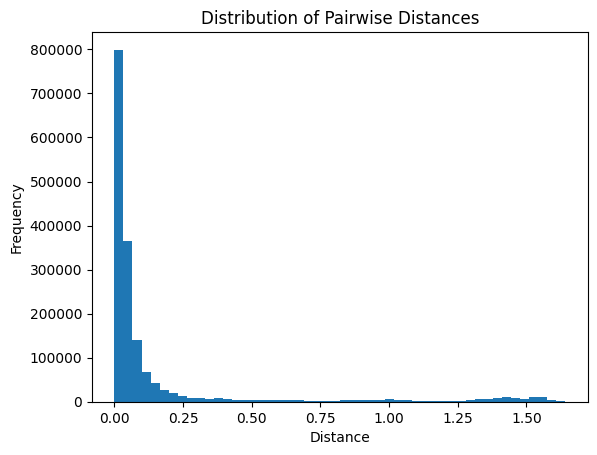

In [ ]:
import matplotlib.pyplot as plt
plt.hist(distance_matrix.flatten(), bins=50)
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.title("Distribution of Pairwise Distances")
plt.show()

### Reclustering with new eps value

In [ ]:
# Apply constrained DBSCAN
eps = 0.03  # Adjust based on distance matrix
min_samples = 2  # Minimum neighbors to form a cluster

adjusted_labels = constrained_dbscan_with_constraints(distance_matrix, eps, min_samples, must_link_pairs, cannot_link_pairs)
print("Adjusted Cluster Labels:", np.unique(adjusted_labels))

Adjusted Cluster Labels: [-1  0  1]


### Visualizing the new clusters

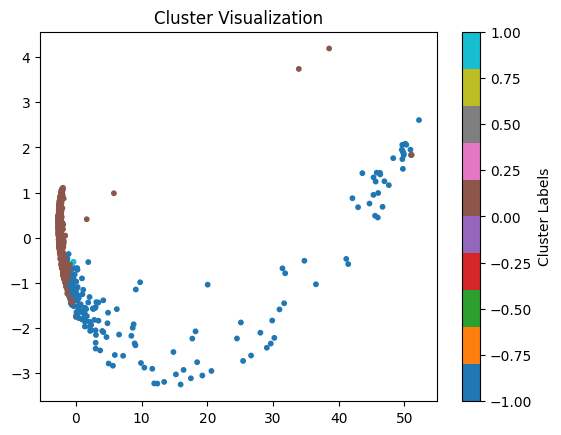

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce to 2D for visualization
reduced_embeddings = PCA(n_components=2).fit_transform(distance_matrix)

# Plot clusters
plt.scatter(
    reduced_embeddings[:, 0], reduced_embeddings[:, 1],
    c=adjusted_labels, cmap='tab10', s=10
)
plt.colorbar(label="Cluster Labels")
plt.title("Cluster Visualization")
plt.show()



### Lets check if the constraint where applied

In [ ]:
# Cannot-link violations
cannot_violations = [
    (i, j) for i, j in cannot_link_pairs if adjusted_labels[i] == adjusted_labels[j] and adjusted_labels[i] != -1
]
print(f"Cannot-Link Violations: {len(cannot_violations)}")

# Must-link violations
must_violations = [
    (i, j) for i, j in must_link_pairs if adjusted_labels[i] != adjusted_labels[j]
]
print(f"Must-Link Violations: {len(must_violations)}")


Cannot-Link Violations: 0
Must-Link Violations: 0


### Check for number of noise points

In [ ]:
noise_points = [i for i, label in enumerate(adjusted_labels) if label == -1]
print(f"Number of Noise Points: {len(noise_points)}")


Number of Noise Points: 178


### Dont forget to reset the memory bank

In [ ]:
# Resetting memory_bank
memory_bank = {}

# Making sure that adjusted_labels are PyToch tensors
adjusted_labels= torch.tensor(adjusted_labels, dtype=torch.int64)

# Move all_embeddings to the desired device (e.g., CPU):
device = 'cuda' if torch.cuda.is_available() else 'cpu'
all_embeddings = all_embeddings.to(device)

#Creating memory bank
memory_bank = initialize_memory_bank(all_embeddings, adjusted_labels)
print(f"Memory Bank Initialized: {memory_bank}")

Memory Bank Initialized: {0: tensor([ 2.0987e-02, -2.5966e-02,  4.0484e-02,  9.8635e-03,  2.6637e-02,
         2.0459e-02, -6.7297e-02, -5.9178e-02,  1.3396e-03, -4.0203e-02,
         1.6755e-02,  4.6560e-02, -6.5275e-03, -6.6976e-02, -6.5084e-02,
        -3.9559e-03,  8.4170e-03, -6.3739e-02, -6.4280e-02,  6.3640e-03,
        -4.1094e-03,  1.6048e-02, -1.0619e-02,  2.7468e-02,  1.2762e-02,
         1.3897e-02, -7.1565e-03,  1.6956e-02,  9.0114e-03,  1.2986e-02,
        -6.8792e-03, -3.6033e-02,  2.6450e-02, -7.1420e-03, -3.2894e-02,
        -2.6375e-02, -1.5799e-02, -1.2964e-02, -5.7992e-02, -3.7296e-03,
        -3.1988e-03, -8.3987e-03, -4.5520e-02, -2.6876e-02,  3.6532e-03,
         3.8420e-02, -4.1268e-02,  1.7625e-03,  4.3612e-02, -1.3398e-02,
         4.5880e-02,  4.2708e-03, -5.2573e-02,  2.8171e-02,  2.2926e-02,
        -7.4701e-02, -6.4030e-03, -3.3880e-02, -4.5563e-02, -4.3735e-02,
         2.0828e-02,  2.1619e-02,  2.7823e-02,  4.3758e-02, -1.7594e-02,
        -3.4811e-02,  

### Time to find the new uncertain pairs

In [ ]:
# Select uncertain pairs
uncertain_positive_pairs, uncertain_negative_pairs = select_uncertain_pairs(distance_matrix, adjusted_labels)

# Display results
print("Uncertain Positive Pairs (within clusters):")
for pair in uncertain_positive_pairs[:10]:
    print(f"Pair: {pair[0]} and {pair[1]}, Distance: {pair[2]:.4f}")

print("\nUncertain Negative Pairs (across clusters):")
for pair in uncertain_negative_pairs[:10]:
    print(f"Pair: {pair[0]} and {pair[1]}, Distance: {pair[2]:.4f}")


Uncertain Positive Pairs (within clusters):
Pair: 750 and 804, Distance: 1.2812
Pair: 172 and 184, Distance: 1.1460

Uncertain Negative Pairs (across clusters):
Pair: 815 and 172, Distance: 0.0183
Pair: 549 and 1055, Distance: 0.0285
Pair: 184 and 1055, Distance: 0.3641


### And now lets annotate them

In [ ]:
all_texts = train_data['TEXT'].tolist() + eval_data['TEXT'].tolist()

# Annotate the selected pairs
must_link_pairs, cannot_link_pairs = annotate_and_update_constraints(
    uncertain_positive_pairs, uncertain_negative_pairs,
    all_texts, must_link_pairs, cannot_link_pairs
)

# Confirm updates
print(f"Updated Must-Link Pairs: {len(must_link_pairs)}")
print(f"Updated Cannot-Link Pairs: {len(cannot_link_pairs)}")


Annotating Uncertain Positive Pairs (Within Clusters):

Pair: (750, 804), Distance: 1.2812
Text 1: texas residents can now sue facebook twitter and youtube for allegedly censoring their content after a federal appeals court side
Text 2: it is so easy to make a news in these days
Should these belong in the same cluster? (y/n): y

Pair: (172, 184), Distance: 1.1460
Text 1: i ’ d rather cut my dick off than watch this trash
Text 2: get these fags in jail asap
Should these belong in the same cluster? (y/n): y

Annotating Uncertain Negative Pairs (Across Clusters):

Pair: (815, 172), Distance: 0.0183
Text 1: i loved this movie
Text 2: i ’ d rather cut my dick off than watch this trash
Should these belong in different clusters? (y/n): y

Pair: (549, 1055), Distance: 0.0285
Text 1: why dont you take concrete steps to stop the inhumanity at the border 
Text 2: make sure you listen for the phrase that pays
Should these belong in different clusters? (y/n): n

Pair: (184, 1055), Distance: 0.3641


In [ ]:
cannot_link_pairs[0]

(172, 1239)

In [ ]:
# Insances 3151 and 4820 where parts on an uncertain positive pair
# Insances 703 and 46 where parts on an uncertain negative pair
all_texts = train_data['TEXT'].tolist() + eval_data['TEXT'].tolist() #+ unlabeled_data['TEXT'].tolist()

# Cluster label 3151 and 4820
print(f"Cluster Label: {adjusted_labels[1239]}")

# Text
print(f"Text: {all_texts[1239]}")


Cluster Label: 0
Text: id like to know mr musk who encouraged you to go to mars and what individual said that you were capable of doing this and what scientific proof did they give you that you could actually do what youre wanting to do


### RETRAIN (the last fine tuned model)!

In [ ]:
import os
import torch
from transformers import BertTokenizer, BertModel
import torch.nn.functional as F

# Load the previously fine-tuned model
fine_tuned_model_path = "/content/Bert-for-text-classification/models/fine_tuned_bert.pth"  # Path to your saved model
model = BertModel.from_pretrained('bert-base-uncased')  # Initialize the model architecture
model.load_state_dict(torch.load(fine_tuned_model_path))  # Load the saved weights
model.train() #set to training mode again

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

# Hyperparameters
batch_size = 32
lambda_t = 1.0  # Weight for L_t
margin = 0.1  # Margin for triplet loss
temperature = 0.5  # Temperature for contrastive loss
num_epochs = 3
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model.to(device)

# Training loop
for epoch in range(num_epochs):
    for i in range(0, len(all_texts), batch_size):
        # Prepare batch data
        batch_texts = all_texts[i:i + batch_size]
        batch_indices = list(range(i, min(i + batch_size, len(all_texts))))
        batch_index_set = set(batch_indices)

        # Tokenize and generate embeddings
        inputs = tokenizer(batch_texts, padding=True, truncation=True, return_tensors="pt", max_length=128)
        inputs = {key: val.to(device) for key, val in inputs.items()}
        outputs = model(**inputs)
        embeddings = outputs.last_hidden_state[:, 0, :]  # [CLS] token embeddings

        # Filter must-link and cannot-link pairs for the current batch
        batch_must_link_pairs = [
            (a, b) for (a, b) in must_link_pairs if a in batch_index_set and b in batch_index_set
        ]
        batch_cannot_link_pairs = [
            (a, b) for (a, b) in cannot_link_pairs if a in batch_index_set and b in batch_index_set
        ]

        # Debugging: Number of pairs in batch
        print(f"Batch {i // batch_size + 1}: Must-Link Pairs in Batch: {len(batch_must_link_pairs)}, "
              f"Cannot-Link Pairs in Batch: {len(batch_cannot_link_pairs)}")

        # Create a mapping from global to batch-local indices
        index_map = {global_idx: local_idx for local_idx, global_idx in enumerate(batch_indices)}

        # Convert global indices in pairs to batch-local indices
        batch_must_link_pairs = [
            (index_map[a], index_map[b]) for (a, b) in batch_must_link_pairs
        ]
        batch_cannot_link_pairs = [
            (index_map[a], index_map[b]) for (a, b) in batch_cannot_link_pairs
        ]

        # Compute losses
        contrastive_loss = calculate_contrastive_loss(memory_bank, embeddings, adjusted_labels[batch_indices], temperature=temperature)
        support_pair_loss = calculate_support_pair_loss(embeddings, batch_must_link_pairs, batch_cannot_link_pairs, margin=margin)

        # Combine losses
        combined_loss = contrastive_loss + lambda_t * support_pair_loss

        # Backpropagation
        optimizer.zero_grad()
        combined_loss.backward()
        optimizer.step()

        # Debugging: Monitor losses
        print(f"Epoch {epoch + 1}, Batch {i // batch_size + 1}: Contrastive Loss = {contrastive_loss.item():.4f}, "
              f"Triplet Loss = {support_pair_loss.item():.4f}, Combined Loss = {combined_loss.item():.4f}")

# Save the fine-tuned model
save_path = "/content/Bert-for-text-classification/models/fine_tuned_bert.pth"
os.makedirs(os.path.dirname(save_path), exist_ok=True)
torch.save(model.state_dict(), save_path)
print(f"Fine-tuned BERT model saved to {save_path}")


<ipython-input-82-8fc7777aaa74>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(fine_tuned_model_path))  # Load the saved weights


Batch 1: Must-Link Pairs in Batch: 0, Cannot-Link Pairs in Batch: 0
Epoch 1, Batch 1: Contrastive Loss = 3.4340, Triplet Loss = 0.0000, Combined Loss = 3.4340
Batch 2: Must-Link Pairs in Batch: 0, Cannot-Link Pairs in Batch: 0
Epoch 1, Batch 2: Contrastive Loss = 3.4657, Triplet Loss = 0.0000, Combined Loss = 3.4657
Batch 3: Must-Link Pairs in Batch: 0, Cannot-Link Pairs in Batch: 0
Epoch 1, Batch 3: Contrastive Loss = 3.4657, Triplet Loss = 0.0000, Combined Loss = 3.4657
Batch 4: Must-Link Pairs in Batch: 0, Cannot-Link Pairs in Batch: 0
Epoch 1, Batch 4: Contrastive Loss = 3.4657, Triplet Loss = 0.0000, Combined Loss = 3.4657
Batch 5: Must-Link Pairs in Batch: 0, Cannot-Link Pairs in Batch: 0
Epoch 1, Batch 5: Contrastive Loss = 3.4340, Triplet Loss = 0.0000, Combined Loss = 3.4340
Batch 6: Must-Link Pairs in Batch: 2, Cannot-Link Pairs in Batch: 0
Anchor 12 has 2 positives.
Anchor 24 has 2 positives.
Epoch 1, Batch 6: Contrastive Loss = 3.3432, Triplet Loss = 0.0000, Combined Loss =